### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import os.path
import time, itertools, re
import importlib
from collections import Counter
import scipy as sc
import miceforest as mf
from sklearn.metrics import make_scorer, balanced_accuracy_score, confusion_matrix, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.inspection import permutation_importance
from HypOpt import lowest_cwacc
import matplotlib.pyplot as plt
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
savetag='pred_lavSQ_MHC'
print(fileloc_data)
code_path='/'.join(os.getcwd().split('/')[0:4])+'/sklvq/'
sys.path.append(code_path)
from sklvq import GMLVQ, LGMLVQ
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
#from EDdata_GGz import cols_type_cast
%load_ext autoreload


/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/


/home/sreejita/anaconda3/envs/py_env1/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Classification

## Hyperparameter selection

In [2]:
%autoreload 2
from GetDataReady import getDataNormalized_Interact, getDataNormalized, get_fname_exp, get_choice
from HypOptClassifiers import grid_search_classifiers, grid_search_lvq
save_dict=get_fname_exp()
choice_dict=get_choice()
savepicklpath='%s/pickles'%(os.getcwd())
sampling_strategy='not majority'
param_grid={'RF_Max_Features': [5,7,10, 20,25], 'RF_n_Trees':[100, 300, 500], 'RF_min_leaf':5,
           'scorer_name':'Lowest_CWA', 'LRL1_C': np.array([0.01, 0.1, 1])}
dataset_types, labs_all={},{}
for key, val in choice_dict.items():
    dataset_types[key]=getDataNormalized(key,0)
    X,Y=dataset_types[key]['zXtrain'], dataset_types[key]['Ytrain']
    labs_all[key]=np.unique(Y)
    if key<3:        
        if X.isnull().sum().sum()>0:
            X,Y=dataset_types[key]['mice_zXtrain'], dataset_types[key]['Ytrain']  
    #grid_search_classifiers(X, Y,sampling_strategy, param_grid)

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling


## Model Training

In [3]:
from modelTraining import model_training, load_trained_models
from model_explanations import feature_imp_all_exp, prototypes, model_feature_weights
from pathlib import Path
all_clf=model_training()

Model exists
Model exists
Model exists
Model exists
Model exists
Model exists
Model exists
Model exists
Model exists


In [3]:
#%autoreload 3
from model_explanations import prototypes_all_exps
prots_all_exps=prototypes_all_exps()

In [8]:
%reload_ext autoreload
from model_explanations import feature_imp_all_exp
fimp_all_exps=feature_imp_all_exp(dataset_types)

In [9]:
#%load_ext autoreload
%reload_ext autoreload
from evaluation import PerfMetrics_Tabulate
display_tab={'show':1,'res_data_opt':2.2,'row_lim':4,'tail_head':'head'}
PerfMetrics_Tabulate(display_tab)

CSV file exists!
CSV file exists!
CSV file exists!
CSV file exists!
CSV file exists!
CSV file exists!
      Clf-Split Acc-Anorexia nervosa    Acc-Binge-ED Acc-Bulimia nervosa  \
0   RF-Training       0.971 (0.006)   0.967 (0.000)       0.743 (0.014)    
1  KNN-Training       0.806 (0.000)   0.767 (0.000)       0.357 (0.000)    
2  LDA-Training       0.887 (0.000)   0.767 (0.000)       0.536 (0.000)    
3  QDA-Training       0.968 (0.000)   1.000 (0.000)       1.000 (0.000)    

       Acc-Others             MAA AUC-Anorexia nervosa    AUC-Binge-ED  \
0  0.067 (0.042)   0.687 (0.370)        0.982 (0.001)   0.987 (0.001)    
1  0.333 (0.000)   0.566 (0.221)        0.874 (0.000)   0.958 (0.000)    
2  0.500 (0.000)   0.672 (0.161)        0.916 (0.000)   0.967 (0.000)    
3  0.889 (0.000)   0.964 (0.045)        0.993 (0.000)   1.000 (0.000)    

  AUC-Bulimia nervosa      AUC-Others         Avg-Wgt  
0      0.980 (0.002)   0.987 (0.002)   0.983 (0.001)   
1      0.885 (0.000)   0.910 (0.00

In [10]:
choice=3.2
use_permutation_imp=['KNN','LDA','QDA','LSVC','RSVC']
select_keys1, classifier_name1=['RF', 'KNN','RSVC', 'LDA','GMLVQ'],['Random Forest', 'K-nearest neighbour', 'SVM w/ RBF',
                                                                    'Linear Discr. Analysis','Generalized Matrix LVQ']
select_keys2=['GNB','LGMLVQ2', 'LogLASSO']
exp_name=save_dict[choice]
X, Y=dataset_types[choice]['zXtrain'], dataset_types[choice]['Ytrain']
nclasses=len(np.unique(Y))
fimp_all=fimp_all_exps[choice]
adapted_combo_cols=X.columns
ind = np.arange(len(adapted_combo_cols)-1)
mean_name, std_name, show_col_names=[],[], []
for idx, col in enumerate(adapted_combo_cols):
    if (col.split('-')[0]=='Main') | (col=='DT-BMI'):
        col=col.split('-')[1]   
    show_col_names.append(' '.join(col.split('_')))
    col='('+col+')'
    all_parts=' '.join(col.split('_'))    
    temp='mean '+ all_parts
    mean_name.append(temp)
    temp='std '+ all_parts
    std_name.append(temp)
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5
res_df_colname=np.column_stack((mean_name, std_name)).flatten()
patterns = [ "/" , "++", "..", "xx", "\\" , "+" , "o", "O", "*", "|"  ]
colors=[np.array([228,26,28])/256, np.array([55,126,184])/256, np.array([77,175,74])/256, np.array([56,108,176])/256, 
        np.array([255,127,0]) /256, np.array([191,91,23])/256, np.array([231,41,138])/256, np.array([247,129,191])/256]
fs=10
print(exp_name)
print(np.unique(Y))

Core-3ED-Others
['Anorexia nervosa' 'Binge-ED' 'Bulimia nervosa' 'Others']


RF (16,)
KNN (16,)
RSVC (16,)
LDA (16,)
GMLVQ (16,)


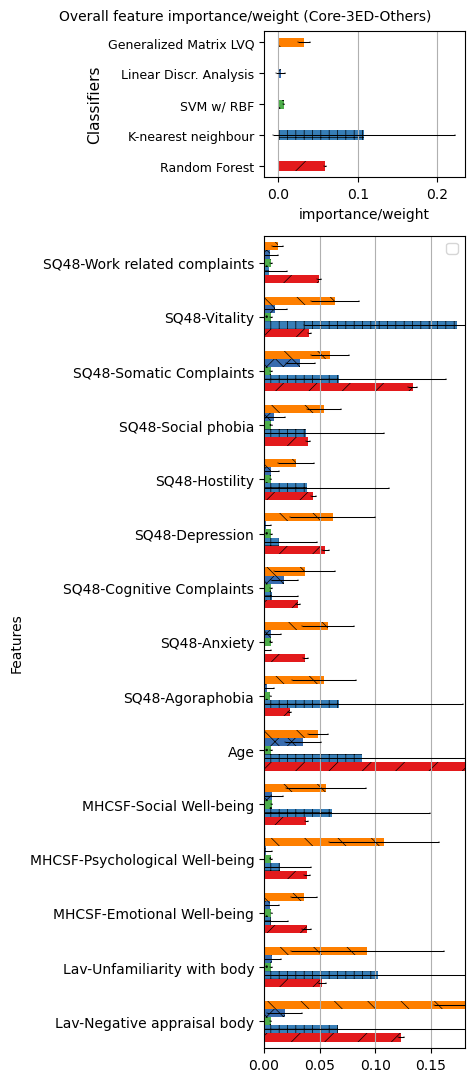

In [11]:
ind2=ind#[1:]
bar_width = 0.15# the width of the bars
shifts=[-0.3,-0.15,0.0,0.15,0.30]#shifts=[-0.4,-0.20,0.0,0.20,0.40]#fig, ax = plt.subplots(1,2, figsize=(9,5))
fig = plt.figure(constrained_layout=True, figsize=(5,11))
widths, ax_all =[0.18,1],[]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=widths)
for colnum in range(2):
    ax_all.append(fig.add_subplot(spec[colnum]))
ax=ax_all[1]
rects_all, bmi_all,fimp_tabulate={},{},{}
for idx,key in enumerate(select_keys1):
    if key in use_permutation_imp:
        bardata, err=np.mean(fimp_all[key]['All'], axis=1), np.std(fimp_all[key]['All'], axis=1)
    else:
        bardata, err=np.mean(fimp_all[key]['All'], axis=0), np.std(fimp_all[key]['All'], axis=0)
    rects_all[key] = ax.barh(ind+shifts[idx], bardata[1:], height=bar_width, xerr=err[1:], label=key, 
                           error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3), hatch=patterns[idx], color=colors[idx])
    print(key, np.shape(bardata))
    #bmi_all[key]={'mean':bardata[0], 'std':err[0]}
    ax_all[0].barh(idx, bardata[0], xerr=err[0], hatch=patterns[idx], height=bar_width*2, color=colors[idx], error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3))
    if idx==0:
        ax_all[0].annotate('BMI', xy=(0.35, 0.1))
    mean_err=(np.column_stack((bardata, err))).flatten()
    fimp_tabulate[key]=mean_err
fimp_tabulate=pd.DataFrame.from_dict(data=fimp_tabulate).T
fimp_tabulate.columns=res_df_colname
ax.set_ylabel('Features', fontsize=fs)
ax.set_yticks(ind)
ax.set_yticklabels(show_col_names[1:], rotation=0, fontsize=fs)
ax.legend('')
ax.grid(axis='x')
ax.set_xlim(0,0.18)
ax.set_ylim(-0.5,len(show_col_names)-1.5)
ax_all[0].set_yticks(np.arange(0,len(select_keys1)))
ax_all[0].set_yticklabels(classifier_name1, rotation=0, fontsize=fs-1)
ax_all[0].set_ylabel('Classifiers', fontsize=fs+1)
ax_all[0].set_xlabel('importance/weight', fontsize=fs)
ax_all[0].grid(axis='x')
fig.suptitle('Overall feature importance/weight (%s)'%exp_name, fontsize=fs)
fig.tight_layout()
plt.show()
#fig.savefig('figs/PDFs/classification/FIMP1%s_vert.pdf'%exp_name, bbox_inches='tight', transparent=False,
#               pad_inches=0.01)
#fig.savefig('figs/PNGs/classification/FIMP1_%s_vert.png'%exp_name, bbox_inches='tight', transparent=True,
#               pad_inches=0.01)